##Car image classification model using the VGG16 convolutional neural network with transfer learning + fine-tuning.

Load Dataset

In [ ]:
!kaggle datasets download -d kshitij192/cars-image-dataset
!unzip cars-image-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset
License(s): GPL-2.0
 94% 34.0M/36.3M [00:02<00:00, 23.4MB/s]
100% 36.3M/36.3M [00:02<00:00, 14.3MB/s]
Archive:  cars-image-dataset.zip
  inflating: Cars Dataset/test/Audi/1000.jpg  
  inflating: Cars Dataset/test/Audi/1003.jpg  
  inflating: Cars Dataset/test/Audi/1008.jpg  
  inflating: Cars Dataset/test/Audi/1020.jpg  
  inflating: Cars Dataset/test/Audi/1022.jpg  
  inflating: Cars Dataset/test/Audi/1025.jpg  
  inflating: Cars Dataset/test/Audi/1027.jpg  
  inflating: Cars Dataset/test/Audi/1038.jpg  
  inflating: Cars Dataset/test/Audi/104.jpg  
  inflating: Cars Dataset/test/Audi/1043.jpg  
  inflating: Cars Dataset/test/Audi/1051.jpg  
  inflating: Cars Dataset/test/Audi/1059.jpg  
  inflating: Cars Dataset/test/Audi/1060.jpg  
  inflating: Cars Dataset/test/Audi/1064.jpg  
  inflating: Cars Dataset/test/Audi/1066.jpg  
  inflating: Cars Dataset/test/Audi/1072.jpg  
  inflating: Cars Dataset/test/Audi/107

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk("/content/Cars Dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/Cars Dataset'.
There are 7 directories and 0 images in '/content/Cars Dataset/train'.
There are 0 directories and 271 images in '/content/Cars Dataset/train/Hyundai Creta'.
There are 0 directories and 775 images in '/content/Cars Dataset/train/Toyota Innova'.
There are 0 directories and 424 images in '/content/Cars Dataset/train/Swift'.
There are 0 directories and 311 images in '/content/Cars Dataset/train/Rolls Royce'.
There are 0 directories and 316 images in '/content/Cars Dataset/train/Mahindra Scorpio'.
There are 0 directories and 814 images in '/content/Cars Dataset/train/Audi'.
There are 0 directories and 441 images in '/content/Cars Dataset/train/Tata Safari'.
There are 7 directories and 0 images in '/content/Cars Dataset/test'.
There are 0 directories and 67 images in '/content/Cars Dataset/test/Hyundai Creta'.
There are 0 directories and 190 images in '/content/Cars Dataset/test/Toyota Innova'.
There are 0 directories and 102 

Set directories

In [ ]:
train_dir = '/content/Cars Dataset/train'
test_dir = '/content/Cars Dataset/test'

Load training & test data

In [ ]:
import tensorflow as tf
IMG_SIZE = (279,279)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 3352 files belonging to 7 classes.
Found 813 files belonging to 7 classes.


Create a checkpoint callback

In [ ]:
checkpoint_path = "Car_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

Data augmentation layer

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation")

Build model using VGG16 (Transfer Learning)

In [ ]:
import keras
base_model = keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=(279,279, 3), name="input_layer")
inputs=keras.applications.vgg16.preprocess_input(inputs)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 279, 279, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling (Gl  (None, 512)               0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 7)                 3591      
                                                                 
Total params: 14718279 (56.15 MB)
Trainable params: 3591 (14.

Train the model (Feature Extraction Phase)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
history_car = model.fit(train_data,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
105/105 [==============================] - 895s 9s/step - loss: 3.2581 - accuracy: 0.3106 - val_loss: 3.0181 - val_accuracy: 0.3021
Epoch 2/5
105/105 [==============================] - 769s 7s/step - loss: 1.9380 - accuracy: 0.4860 - val_loss: 2.5009 - val_accuracy: 0.3646
Epoch 3/5
105/105 [==============================] - 662s 6s/step - loss: 1.5533 - accuracy: 0.5471 - val_loss: 1.3164 - val_accuracy: 0.6562
Epoch 4/5
105/105 [==============================] - 680s 6s/step - loss: 1.2879 - accuracy: 0.6080 - val_loss: 0.6196 - val_accuracy: 0.8125
Epoch 5/5
105/105 [==============================] - 612s 6s/step - loss: 1.1691 - accuracy: 0.6387 - val_loss: 0.6021 - val_accuracy: 0.8229


Evaluate the model

In [ ]:
results = model.evaluate(test_data)

26/26 [==============================] - 11s 414ms/step - loss: 0.8855 - accuracy: 0.7478


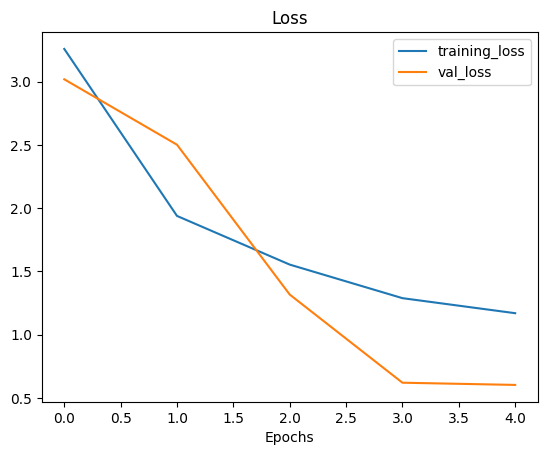

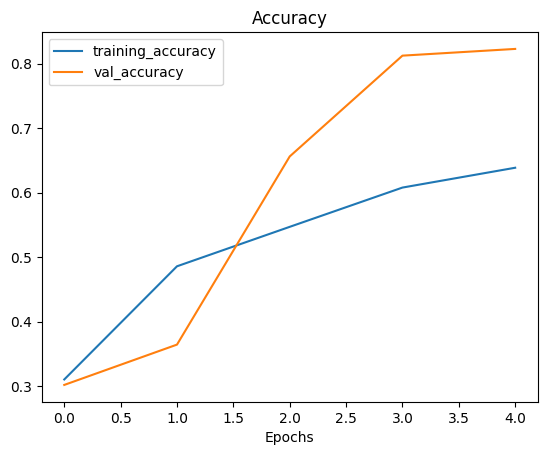

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
plot_loss_curves(history_car)

##Fine-tune (Unfreeze last 5 layers of VGG16)

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10

history_finetune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_car.epoch[-1])

Epoch 5/10
105/105 [==============================] - 619s 6s/step - loss: 1.2988 - accuracy: 0.5680 - val_loss: 0.4071 - val_accuracy: 0.8333
Epoch 6/10
105/105 [==============================] - 551s 5s/step - loss: 0.5582 - accuracy: 0.8174 - val_loss: 0.3596 - val_accuracy: 0.9062
Epoch 7/10
105/105 [==============================] - 504s 5s/step - loss: 0.3413 - accuracy: 0.8884 - val_loss: 0.0585 - val_accuracy: 0.9583
Epoch 8/10
105/105 [==============================] - 499s 5s/step - loss: 0.2851 - accuracy: 0.9141 - val_loss: 0.0252 - val_accuracy: 0.9896
Epoch 9/10
105/105 [==============================] - 473s 5s/step - loss: 0.2302 - accuracy: 0.9239 - val_loss: 0.0850 - val_accuracy: 0.9688
Epoch 10/10
105/105 [==============================] - 491s 5s/step - loss: 0.1449 - accuracy: 0.9550 - val_loss: 0.0629 - val_accuracy: 0.9792


In [ ]:
results_ = model.evaluate(test_data)
results_

26/26 [==============================] - 6s 237ms/step - loss: 0.1283 - accuracy: 0.9619


[0.12828262150287628, 0.9618695974349976]

Compare results

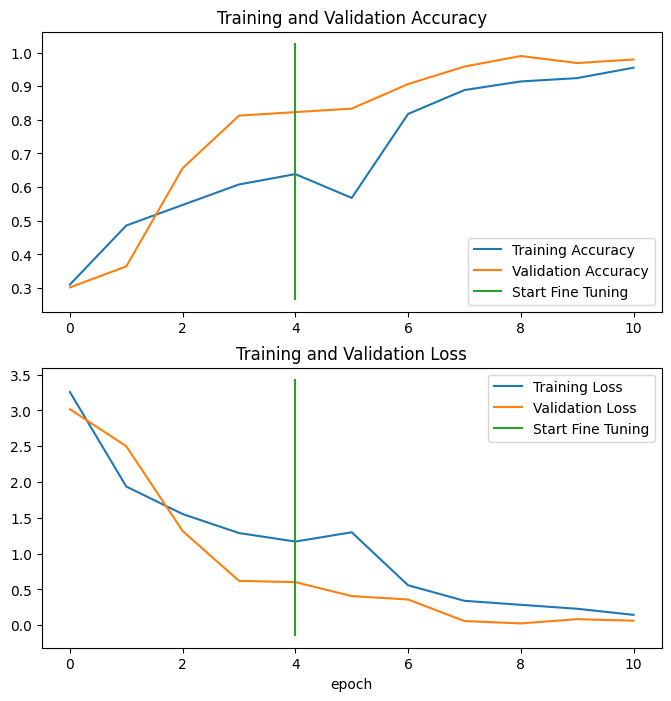

In [ ]:
compare_historys(original_history=history_car,
                 new_history=history_finetune,
                 initial_epochs=5)